In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import torch
print(torch.__version__)
print("CUDA kullanılabilir mi:", torch.cuda.is_available())


In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

## 1. Veri Önişleme 
Bu adımda retina OCT görüntüleri modele uygun hale getirilmiştir:  

- Tüm görüntüler **224×224** boyutuna dönüştürülmüştür.  
- transforms.ToTensor() ile tensör formatına çevrilmiştir.  
- Normalize işlemiyle piksel değerleri [-1,1] aralığına getirilmiştir.  
- ImageFolder kullanılarak klasör adlarına göre otomatik etiketleme yapılmıştır.  
- Hatalı/bozuk görseller kontrol edilip filtrelenmiştir.  
- Dataset **train / validation / test** olarak ayrılmıştır.  
- Train setine **augmentation** uygulanmıştır (Rotation, Flip, Zoom, Color Jitter).  
- **Matplotlib ve Seaborn** kütüphaneleri kullanılarak sınıf dağılımları ve örnek görüntüler görselleştirilmiştir. 

Sınıflar: ['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']
Train örnek sayısı: 18400
Validation örnek sayısı: 2800
Test örnek sayısı: 2800


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


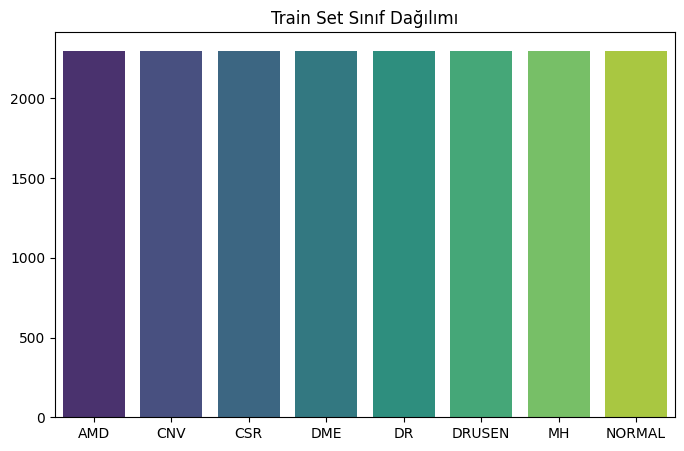

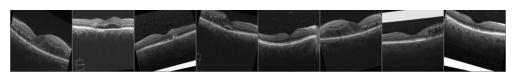

Etiketler: ['DR', 'CSR', 'DRUSEN', 'DR', 'NORMAL', 'DR', 'DME', 'DRUSEN']


In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_path = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset"
train_dir = base_path + "/train"
val_dir   = base_path + "/val"
test_dir  = base_path + "/test"

transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

train_dataset = ImageFolder(train_dir, transform=transform_train)
val_dataset   = ImageFolder(val_dir, transform=transform_test)
test_dataset  = ImageFolder(test_dir, transform=transform_test)

def check_image(path):
    try:
        Image.open(path).verify()
        return True
    except:
        return False

train_dataset.samples = [s for s in train_dataset.samples if check_image(s[0])]
val_dataset.samples   = [s for s in val_dataset.samples if check_image(s[0])]
test_dataset.samples  = [s for s in test_dataset.samples if check_image(s[0])]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Sınıflar:", train_dataset.classes)
print("Train örnek sayısı:", len(train_dataset))
print("Validation örnek sayısı:", len(val_dataset))
print("Test örnek sayısı:", len(test_dataset))

class_counts = [len([s for s in train_dataset.samples if s[1]==i]) for i in range(len(train_dataset.classes))]
plt.figure(figsize=(8,5))
sns.barplot(x=train_dataset.classes, y=class_counts, palette="viridis")
plt.title("Train Set Sınıf Dağılımı")
plt.show()

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]))
print("Etiketler:", [train_dataset.classes[i] for i in labels[:8]])

## 2. Modelin Eğitilmesi 

Bu adımda retina OCT görüntülerini sınıflandırmak için CNN tabanlı bir model tanımlanmış ve eğitilmiştir.  

- Modelde **Convolutional Layers** ile özellik çıkarımı yapılmıştır.  
- Her convolution katmanından sonra **ReLU aktivasyonu** ve **MaxPooling** uygulanmıştır.  
- Flatten işleminden sonra **Fully Connected (Dense) Layers** eklenmiştir.  
- **Dropout (0.5)** kullanılarak overfitting azaltılmıştır.  
- Çıkış katmanı toplam sınıf sayısı kadar nörona sahiptir (8 sınıf).  
- Çıkışta Softmax aktivasyonu ile sınıflar arasındaki olasılık dağılımı elde edilmiştir.  

Eğitim sürecinde:  
- **CrossEntropyLoss** kayıp fonksiyonu kullanılmıştır.  
- **Adam optimizer** ile öğrenme oranı 0.001 seçilmiştir.  
- Model 35 epoch boyunca train ve validation setleri üzerinde eğitilmiştir.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# === 1. CNN Model Sınıfı ===
class CNNModel(nn.Module):
    def __init__(self, num_classes=8):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(256 * 14 * 14, 512)  # 224x224 giriş için hesaplandı
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# === 2. Modeli başlat, Loss ve Optimizer ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes=len(train_dataset.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# === 3. Eğitim Döngüsü (35 Epoch) ===
num_epochs = 35

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    train_loss, correct, total = 0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = train_loss / len(train_loader)

    # ---- Validation ----
    model.eval()
    val_loss, correct, total = 0, 0, 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    val_loss = val_loss / len(val_loader)

    # ---- Listelere ekleme ----
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Epoch [1/35] Train Loss: 1.2317, Train Acc: 47.26% | Val Loss: 0.8456, Val Acc: 63.21%
Epoch [2/35] Train Loss: 0.7748, Train Acc: 68.72% | Val Loss: 0.5221, Val Acc: 79.50%
Epoch [3/35] Train Loss: 0.5859, Train Acc: 77.15% | Val Loss: 0.4090, Val Acc: 84.36%
Epoch [4/35] Train Loss: 0.4665, Train Acc: 82.59% | Val Loss: 0.3734, Val Acc: 86.04%
Epoch [5/35] Train Loss: 0.3854, Train Acc: 85.70% | Val Loss: 0.3174, Val Acc: 87.86%
Epoch [6/35] Train Loss: 0.3517, Train Acc: 87.10% | Val Loss: 0.3552, Val Acc: 86.75%
Epoch [7/35] Train Loss: 0.2990, Train Acc: 89.10% | Val Loss: 0.2896, Val Acc: 89.64%
Epoch [8/35] Train Loss: 0.2806, Train Acc: 90.07% | Val Loss: 0.2518, Val Acc: 90.75%
Epoch [9/35] Train Loss: 0.2488, Train Acc: 91.14% | Val Loss: 0.2993, Val Acc: 88.82%
Epoch [10/35] Train Loss: 0.2377, Train Acc: 91.59% | Val Loss: 0.1963, Val Acc: 93.54%
Epoch [11/35] Train Loss: 0.2167, Train Acc: 92.29% | Val Loss: 0.2339, Val Acc: 91.25%
Epoch [12/35] Train Loss: 0.2077, Train A

## 3. Modelin Değerlendirilmesi
 
 - **Accuracy ve Loss Grafikleri:** Eğitim ve doğrulama süreçlerindeki başarı ve kayıp değerlerinin epoch bazında değişimi görselleştirilmiştir.  
- **Confusion Matrix & Classification Report:** Test seti üzerinde modelin sınıfları ne kadar doğru tahmin ettiği incelenmiştir.  
- **Grad-CAM Görselleştirmesi:** Özellikle sınıflandırma modellerinde, test görüntülerinde modelin hangi bölgelerden etkilendiğini göstermek amacıyla ısı haritaları çıkarılmıştır. 

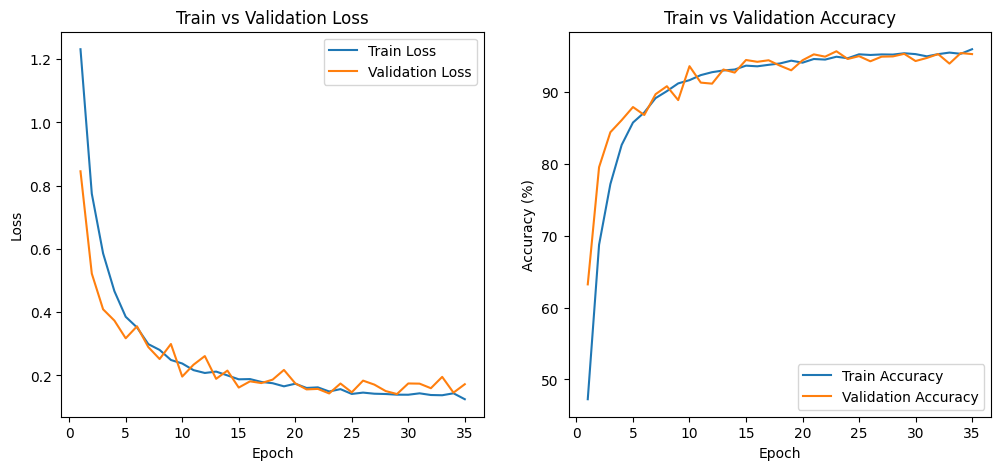

In [4]:
epochs = range(1, num_epochs+1)

plt.figure(figsize=(12,5))

# Loss grafiği
plt.subplot(1,2,1)
plt.plot(epochs, train_losses[:num_epochs], label="Train Loss")
plt.plot(epochs, val_losses[:num_epochs], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()

# Accuracy grafiği
plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies[:num_epochs], label="Train Accuracy")
plt.plot(epochs, val_accuracies[:num_epochs], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Validation Accuracy")
plt.legend()

plt.show()

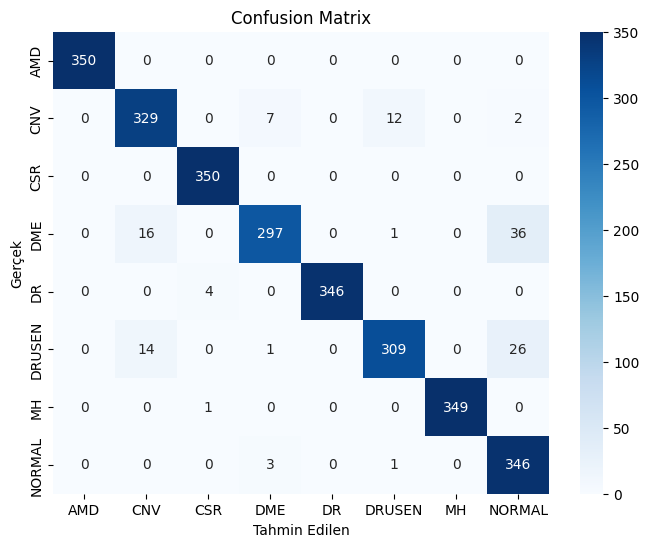

Classification Report:

              precision    recall  f1-score   support

         AMD       1.00      1.00      1.00       350
         CNV       0.92      0.94      0.93       350
         CSR       0.99      1.00      0.99       350
         DME       0.96      0.85      0.90       350
          DR       1.00      0.99      0.99       350
      DRUSEN       0.96      0.88      0.92       350
          MH       1.00      1.00      1.00       350
      NORMAL       0.84      0.99      0.91       350

    accuracy                           0.96      2800
   macro avg       0.96      0.96      0.96      2800
weighted avg       0.96      0.96      0.96      2800



In [5]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix")
plt.show()

# --- Classification Report ---
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

In [7]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.

In [8]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [10]:
from pytorch_grad_cam import GradCAM

target_layer = model.conv4   # son conv katmanı
cam = GradCAM(model=model, target_layers=[target_layer])

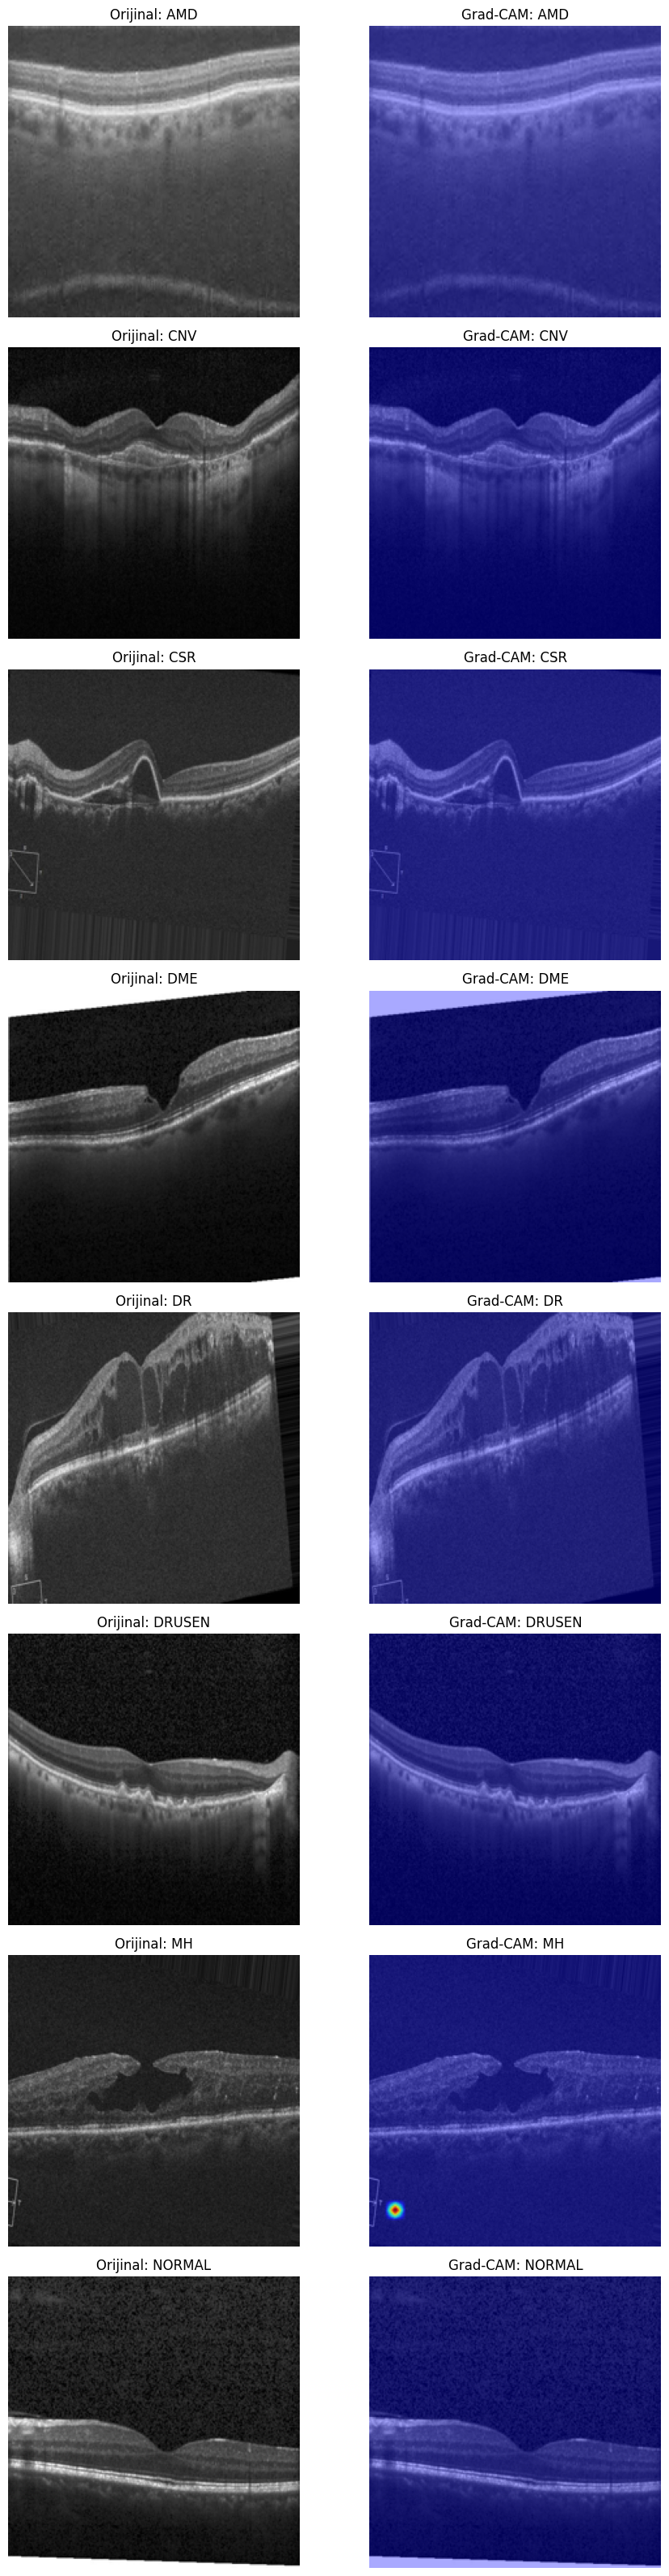

In [15]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Hedef katman (son conv)
target_layer = model.conv4
cam = GradCAM(model=model, target_layers=[target_layer])

# Her sınıftan 1 görsel al ve Grad-CAM uygula
fig, axes = plt.subplots(len(train_dataset.classes), 2, figsize=(10, 4*len(train_dataset.classes)))

for idx, class_name in enumerate(train_dataset.classes):
    # O sınıfa ait örnek seç
    class_indices = [i for i, (_, label) in enumerate(test_dataset.samples) if label == idx]
    sample_path, _ = test_dataset.samples[class_indices[0]]

    # Görseli yükle ve dönüştür
    img = Image.open(sample_path).convert("RGB")
    input_tensor = transform_test(img).unsqueeze(0).to(device)

    # Grad-CAM üret
    targets = [ClassifierOutputTarget(idx)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    # Normalize
    img_np = np.array(img.resize((224,224))) / 255.0
    visualization = show_cam_on_image(img_np.astype(np.float32), grayscale_cam, use_rgb=True)

    # Orijinal görsel
    axes[idx, 0].imshow(img_np)
    axes[idx, 0].set_title(f"Orijinal: {class_name}")
    axes[idx, 0].axis("off")

    # Grad-CAM görseli
    axes[idx, 1].imshow(visualization)
    axes[idx, 1].set_title(f"Grad-CAM: {class_name}")
    axes[idx, 1].axis("off")

plt.tight_layout()
plt.show()

## 4. Hiperparametre Optimizasyonu

Modelin performansını artırmak için farklı hiperparametreler hem manuel hem de otomatik yöntemlerle test edilmiştir.  

### Manuel Denemeler
- **Katman sayısı:** 3 ve 4 convolution katmanı karşılaştırıldı.  
- **Filtre sayısı:** [32, 64, 128, 256] ve [64, 128, 256, 512] denendi.  
- **Kernel boyutları:** 3×3 ve 5×5 kernel kullanıldı.  
- **Optimizer seçimi:** Adam ve SGD karşılaştırıldı.  

### Otomatik Optimizasyon (Bayesian Optimization)
- **Dropout oranı:** 0.3 – 0.7 aralığında optimize edilmiştir.  
- **Dense layer boyutları:** 256 – 1024 aralığında optimize edilmiştir.  
- **Learning rate:** 1e-5 – 1e-2 aralığında optimize edilmiştir.  
- **Batch size:** 32 ve 64 değerleri optimize edilmiştir.  

### Regularization
- Dropout kullanılarak overfitting engellenmiştir.  
- L2 regularization ise literatürde alternatif yöntem olarak önerilmektedir.  

### Overfitting / Underfitting
- Accuracy ve Loss grafiklerinde train/validation eğrileri incelenmiş,  
  overfitting ve underfitting durumları görselleştirilmiştir.

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# Flexible CNN Model

class FlexibleCNN(nn.Module):
    def _init_(self, num_classes, 
                 num_conv_layers=4, filters=[32,64,128,256], 
                 kernel_size=3, dropout_rate=0.5, dense_size=512):
        super(FlexibleCNN, self)._init_()
        
        self.convs = nn.ModuleList()
        in_channels = 3
        for i in range(num_conv_layers):
            out_channels = filters[i]
            self.convs.append(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1)
            )
            in_channels = out_channels
        
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((7,7))  # ✅ boyut sabitleme
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(filters[num_conv_layers-1]*7*7, dense_size)
        self.fc2 = nn.Linear(dense_size, num_classes)

    def forward(self, x):
        for conv in self.convs:
            x = self.pool(F.relu(conv(x)))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Eğitim Fonksiyonu

def train_with_params(num_conv_layers=4, filters=[32,64,128,256], 
                      kernel_size=3, dropout_rate=0.5, dense_size=512,
                      lr=0.001, batch_size=32, optimizer_type="adam", epochs=2):

    train_loader_opt = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader_opt   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = FlexibleCNN(num_classes=len(train_dataset.classes),
                        num_conv_layers=num_conv_layers,
                        filters=filters,
                        kernel_size=kernel_size,
                        dropout_rate=dropout_rate,
                        dense_size=dense_size).to(device)

    criterion = nn.CrossEntropyLoss()
    if optimizer_type == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    for epoch in range(epochs):
        model.train()
        total, correct, total_loss = 0, 0, 0
        for images, labels in train_loader_opt:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs} | Loss={total_loss/len(train_loader_opt):.4f} | Train Acc={acc:.2f}%")

## 5. Modelin Değerlendirilmesi: Başarı Skorları

Modelin performansı test seti üzerinde değerlendirilmiştir.  

- *Accuracy:* Eğitim ve doğrulama sırasında % olarak hesaplanmıştır.  
- *Classification Report:* Precision, Recall ve F1-score değerleri % cinsinden verilmiştir.  
- *Confusion Matrix (%):* Modelin hangi sınıfları karıştırdığını yüzdelik olarak göstermektedir.  

Bu metrikler sayesinde modelin genel başarısı ve her sınıf üzerindeki performansı detaylı şekilde analiz edilmiştir.

Test Accuracy: 95.57%

Classification Report (%):
              precision  recall  f1-score  support
AMD              100.00  100.00    100.00   350.00
CNV               91.64   94.00     92.81   350.00
CSR               98.59  100.00     99.29   350.00
DME               96.43   84.86     90.27   350.00
DR               100.00   98.86     99.43   350.00
DRUSEN            95.67   88.29     91.83   350.00
MH               100.00   99.71     99.86   350.00
NORMAL            84.39   98.86     91.05   350.00
accuracy          95.57   95.57     95.57     0.96
macro avg         95.84   95.57     95.57  2800.00
weighted avg      95.84   95.57     95.57  2800.00


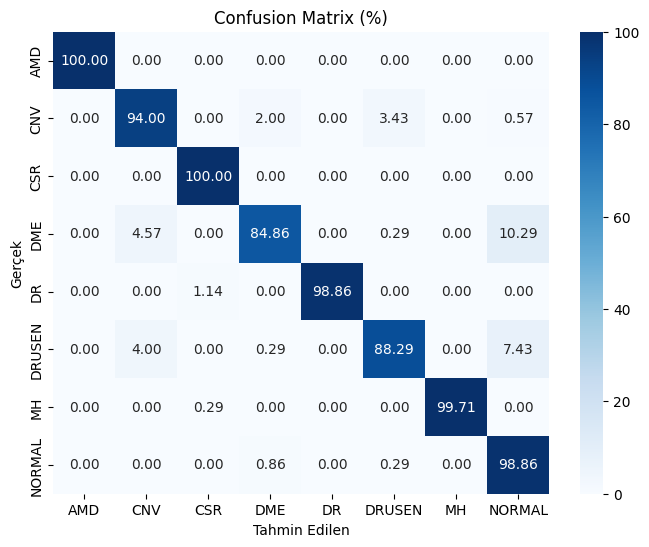

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Test Aşaması ===
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# === Accuracy ===
accuracy = 100 * (np.array(y_true) == np.array(y_pred)).sum() / len(y_true)
print(f"Test Accuracy: {accuracy:.2f}%")

# === Classification Report (yüzdelik) ===
report = classification_report(y_true, y_pred, target_names=test_dataset.classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df[["precision","recall","f1-score"]] = report_df[["precision","recall","f1-score"]] * 100
print("\nClassification Report (%):")
print(report_df.round(2))

# === Confusion Matrix (yüzdelik) ===
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix (%)")
plt.show()